# DRW Crypto Market Prediction - Advanced Pipeline 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import time
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading

In [2]:
train = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/train.parquet')
test = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/test.parquet')

In [3]:
train.shape
test.shape

(538150, 896)

In [4]:
train.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525887 entries, 2023-03-01 00:00:00 to 2024-02-29 23:59:00
Columns: 896 entries, bid_qty to label
dtypes: float64(896)
memory usage: 3.5 GB


## Optimize Memory

In [6]:
def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

In [7]:
train.isnull().sum().sum()

0

##  Handle Infinite Values

In [8]:
train_infs = np.isinf(train.values).sum()
test_infs = np.isinf(test.values).sum()

In [9]:

print(f"Infs in Train: {train_infs}, Infs in Test: {test_infs}")

Infs in Train: 11043627, Infs in Test: 11301150


In [10]:
train_inf_counts = np.isinf(train).sum(axis=0)
test_inf_counts = np.isinf(test).sum(axis=0)

inf_summary = pd.DataFrame({
    'Train Inf Count': train_inf_counts,
    'Test Inf Count': test_inf_counts
})

columns_with_inf = inf_summary[(inf_summary['Train Inf Count'] > 0) | (inf_summary['Test Inf Count'] > 0)]

print(" Columns containing inf values:")
print(columns_with_inf.sort_values(by='Train Inf Count', ascending=False))


 Columns containing inf values:
      Train Inf Count  Test Inf Count
X697           525887          538150
X698           525887          538150
X699           525887          538150
X700           525887          538150
X701           525887          538150
X702           525887          538150
X703           525887          538150
X704           525887          538150
X705           525887          538150
X706           525887          538150
X707           525887          538150
X708           525887          538150
X709           525887          538150
X710           525887          538150
X711           525887          538150
X712           525887          538150
X713           525887          538150
X714           525887          538150
X715           525887          538150
X716           525887          538150
X717           525887          538150


In [11]:
columns_with_inf_values = inf_summary[
    (inf_summary['Train Inf Count'] > 0) | (inf_summary['Test Inf Count'] > 0)
].index.tolist()


train.drop(columns=columns_with_inf_values, inplace=True)
test.drop(columns=columns_with_inf_values, inplace=True)

##  Sample the Data (Optional for Speed)

In [12]:
train = train.sample(frac=0.5, random_state=42)

##  Visualize the Target Distribution 

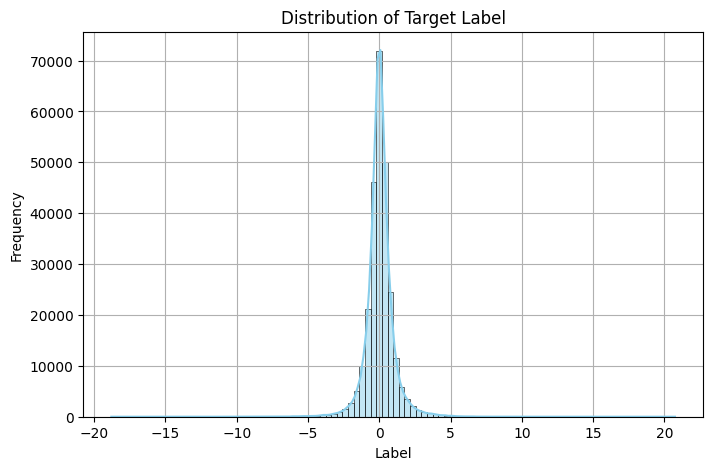

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(train['label'], bins=100, kde=True, color='skyblue')
plt.title('Distribution of Target Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##  Train/Validation Split & Feature Selection

In [14]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42)

X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_valid = valid_df.drop(columns=['label'])
y_valid = valid_df['label']

In [15]:
selector = SelectKBest(score_func=f_regression, k=100)
X_train = selector.fit_transform(X_train, y_train)
X_valid = selector.transform(X_valid)

##  Train XGBoost Model

In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [17]:
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'gpu_hist',  
    'eval_metric': 'rmse',
    'seed': 42
}

evallist = [(dtrain, 'train'), (dvalid, 'valid')]

In [18]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    evals=evallist,
    early_stopping_rounds=30,
    verbose_eval=100
)

[0]	train-rmse:1.01230	valid-rmse:1.01191
[100]	train-rmse:0.95085	valid-rmse:0.95159
[200]	train-rmse:0.90766	valid-rmse:0.91042
[300]	train-rmse:0.87392	valid-rmse:0.87863
[400]	train-rmse:0.84626	valid-rmse:0.85244
[500]	train-rmse:0.82046	valid-rmse:0.82780
[600]	train-rmse:0.79846	valid-rmse:0.80692
[700]	train-rmse:0.77749	valid-rmse:0.78749
[800]	train-rmse:0.75662	valid-rmse:0.76775
[900]	train-rmse:0.73766	valid-rmse:0.75012
[1000]	train-rmse:0.72077	valid-rmse:0.73451
[1100]	train-rmse:0.70469	valid-rmse:0.71949
[1200]	train-rmse:0.68814	valid-rmse:0.70420
[1300]	train-rmse:0.67353	valid-rmse:0.69075
[1400]	train-rmse:0.65910	valid-rmse:0.67744
[1500]	train-rmse:0.64494	valid-rmse:0.66468
[1600]	train-rmse:0.63134	valid-rmse:0.65212
[1700]	train-rmse:0.61804	valid-rmse:0.64038
[1800]	train-rmse:0.60578	valid-rmse:0.62923
[1900]	train-rmse:0.59389	valid-rmse:0.61845
[2000]	train-rmse:0.58236	valid-rmse:0.60816
[2100]	train-rmse:0.57142	valid-rmse:0.59821
[2200]	train-rmse:0.56

##  Train LightGBM Model

In [19]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid)

In [20]:
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

In [21]:
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    num_boost_round=10000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=100)  # بدل verbose_eval
    ]
)


Training until validation scores don't improve for 30 rounds
[100]	train's rmse: 0.946872	valid's rmse: 0.947101
[200]	train's rmse: 0.906416	valid's rmse: 0.907428
[300]	train's rmse: 0.874858	valid's rmse: 0.877058
[400]	train's rmse: 0.848689	valid's rmse: 0.851908
[500]	train's rmse: 0.826022	valid's rmse: 0.830462
[600]	train's rmse: 0.806302	valid's rmse: 0.811636
[700]	train's rmse: 0.787632	valid's rmse: 0.794281
[800]	train's rmse: 0.769993	valid's rmse: 0.777796
[900]	train's rmse: 0.753445	valid's rmse: 0.762475
[1000]	train's rmse: 0.737881	valid's rmse: 0.748003
[1100]	train's rmse: 0.723442	valid's rmse: 0.73455
[1200]	train's rmse: 0.709653	valid's rmse: 0.721879
[1300]	train's rmse: 0.696399	valid's rmse: 0.709709
[1400]	train's rmse: 0.683936	valid's rmse: 0.698224
[1500]	train's rmse: 0.671792	valid's rmse: 0.68714
[1600]	train's rmse: 0.659629	valid's rmse: 0.675958
[1700]	train's rmse: 0.647857	valid's rmse: 0.665039
[1800]	train's rmse: 0.637111	valid's rmse: 0.655

##  Compare Models (Time & RMSE)

In [22]:
def plot_rmse_and_time(results):
    df = pd.DataFrame(results)

    # Training Time
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='Train Time (s)', data=df, palette='Blues_d')
    plt.title(" Training Time Comparison")
    plt.ylabel("Seconds")
    plt.grid(True)
    plt.show()

    # RMSE
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='RMSE', data=df, palette='Reds_d')
    plt.title("RMSE Comparison on Validation Set")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

Training XGBoost...
 Training LightGBM...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 0.298109	valid's rmse: 0.357362


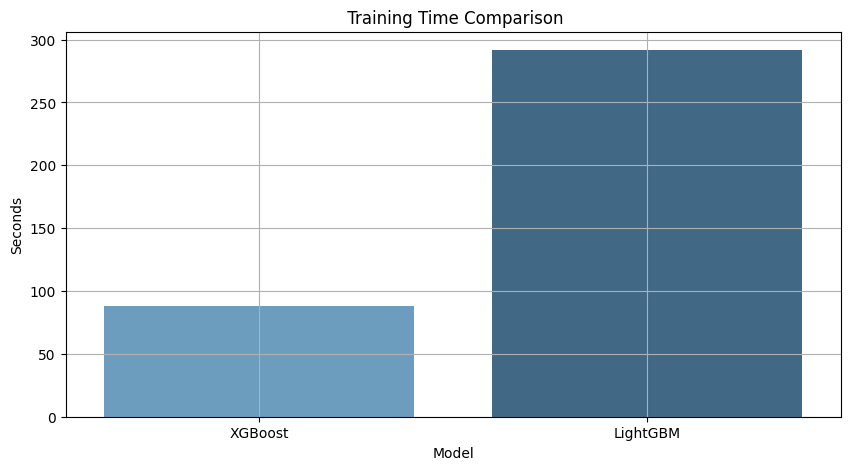

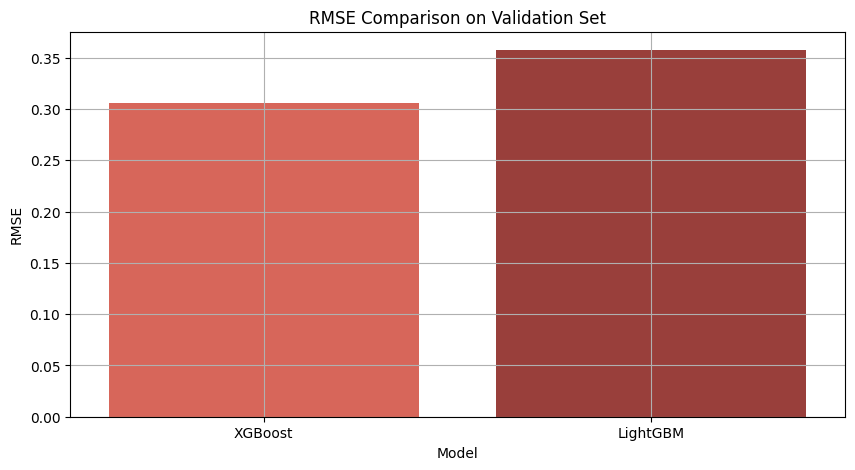

In [23]:
print("Training XGBoost...")
start_xgb = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

xgb_results = {}
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    early_stopping_rounds=30,
    evals_result=xgb_results,
    verbose_eval=False
)

end_xgb = time.time()
xgb_time = end_xgb - start_xgb

xgb_preds = xgb_model.predict(dvalid)
xgb_rmse = mean_squared_error(y_valid, xgb_preds, squared=False)

# -------------------- LightGBM ------------------------
print(" Training LightGBM...")
start_lgb = time.time()

lgb_train_data = lgb.Dataset(X_train, label=y_train)
lgb_valid_data = lgb.Dataset(X_valid, label=y_valid)

lgb_results = {}
lgb_model = lgb.train(
    lgb_params,
    lgb_train_data,
    valid_sets=[lgb_train_data, lgb_valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=10000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=0),
        lgb.record_evaluation(lgb_results)
    ]
)

end_lgb = time.time()
lgb_time = end_lgb - start_lgb

lgb_preds = lgb_model.predict(X_valid)
lgb_rmse = mean_squared_error(y_valid, lgb_preds, squared=False)

# -------------------- Results Table + Plot ------------------------
results = [
    {'Model': 'XGBoost', 'Train Time (s)': xgb_time, 'RMSE': xgb_rmse},
    {'Model': 'LightGBM', 'Train Time (s)': lgb_time, 'RMSE': lgb_rmse},
]

plot_rmse_and_time(results)

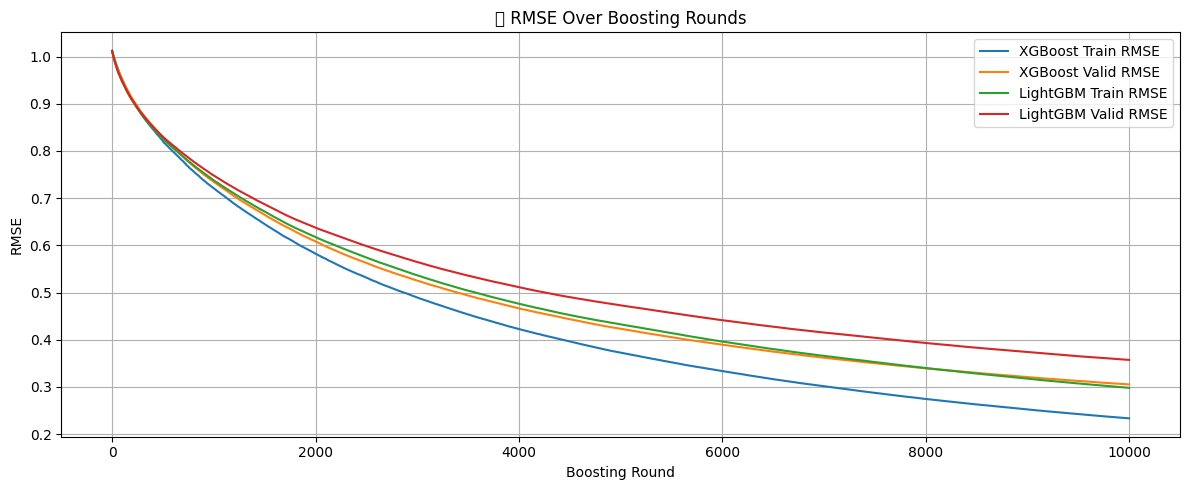

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(xgb_results['train']['rmse'], label='XGBoost Train RMSE')
plt.plot(xgb_results['valid']['rmse'], label='XGBoost Valid RMSE')
plt.plot(lgb_results['train']['rmse'], label='LightGBM Train RMSE')
plt.plot(lgb_results['valid']['rmse'], label='LightGBM Valid RMSE')
plt.title("📊 RMSE Over Boosting Rounds")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importances


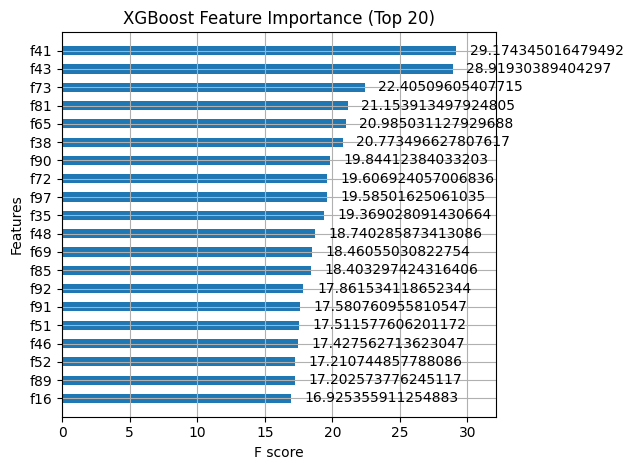

In [25]:
# XGBoost Importance
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', title='XGBoost Feature Importance (Top 20)', height=0.5)
plt.tight_layout()
plt.show()

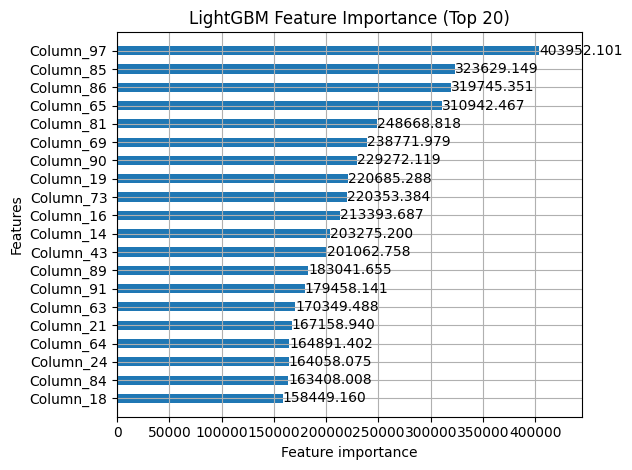

In [26]:
# LightGBM Importance
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', title='LightGBM Feature Importance (Top 20)', height=0.5)
plt.tight_layout()
plt.show()

 ## Submission

In [27]:

Submission = pd.read_csv('/kaggle/input/drw-crypto-market-prediction/sample_submission.csv')

In [28]:

columns_to_drop = [col for col in columns_with_inf_values if col in test.columns]

test.drop(columns=columns_to_drop, inplace=True)

X_test = test.drop(columns=['label'], errors='ignore')

X_test_selected = selector.transform(X_test)
dtest = xgb.DMatrix(X_test_selected)
predictions = model.predict(dtest)

submission = pd.DataFrame({
    'ID': test.index + 1,
    'prediction': predictions
})

submission.to_csv('submission.csv', index=False)
